# Train a CNN regression network to estimate the diameter (mm) from the amodal and visible masks

In [1]:
# import some common libraries
import numpy as np
from numpy.linalg import inv
import os
import cv2
import random
import tifffile
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from PIL import Image

# import some miscellaneous libraries
from utils import visualize
from utils import statistics

# import the libraries that are needed to train the deep learning regression network
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
from torchvision.transforms import functional as F
from torch.autograd import Variable
import skimage.transform

# initialize the computing device (gpu 0 - NVIDIA Geforce GTX 1080Ti)
os.environ["CUDA_VISIBLE_DEVICES"]="0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Dataset class

In [2]:
# this class is altered from class MonkeySpecies10Dataset from the opencv course (week 7)
class regression_dataset(Dataset):
    def __init__(self, data_root, normalization_values, train=True, image_shape=None, transform=None):
        # set image_resize attribute
        if image_shape is not None:
            if isinstance(image_shape, int):
                self.image_shape = (image_shape, image_shape)
            
            elif isinstance(image_shape, tuple) or isinstance(image_shape, list):
                assert len(image_shape) == 1 or len(image_shape) == 2, 'Invalid image_shape tuple size'
                if len(image_shape) == 1:
                    self.image_shape = (image_shape[0], image_shape[0])
                else:
                    self.image_shape = image_shape
            else:
                raise NotImplementedError 
        else:
            self.image_shape = image_shape
            
        # set the normalization values
        self.norm_values = normalization_values
            
        # set transform attribute
        self.transform = transform
        
        # initialize the data dictionary
        self.data_dict = {
            'image_path': [],
            'label': []
        }
        
        # training data path, this will be used as data root if train = True
        if train:
            img_dir = os.path.join(data_root, 'train')
            
        # validation data path, this will be used as data root if train = False
        else:
            img_dir = os.path.join(data_root, 'val')
            
        for img in os.listdir(img_dir):
            if img.endswith(".jpg") or img.endswith(".png") or img.endswith(".tiff"):
                img_path = os.path.join(img_dir, img)
                self.data_dict['image_path'].append(img_path)

                # get the diameter from the text file
                basename, file_extension = os.path.splitext(img)
                labelname = basename + ".txt"
                file1 = open(os.path.join(img_dir, labelname),'r')  
                labelstr = file1.read()
                d = np.float32(labelstr)
                self.data_dict['label'].append(d)

                    
    def __len__(self):
        return len(self.data_dict['label'])
    
    
    def __getitem__(self, idx):
        """
        For given index, return images with resize and preprocessing.
        """
        
        image = tifffile.imread(self.data_dict['image_path'][idx])


        if self.image_shape is not None:
            # alternative for transforms.Resize
            image = skimage.transform.resize(image, self.image_shape, preserve_range=True)
            
  
        if self.transform is not None:
            # alternative for transforms.CenterCrop  
            width, height = image.shape[:2]
            startx = int((width - 224)/2)
            starty = int((height - 224)/2)
            image = image[startx:startx+224, starty:starty+224, :]

            # normalize the xyza image channels so that they are in between 0-1
            for i in range(image.shape[-1]):
                idx1 = (i*2)
                idx2 = (i*2)+1
                
                min_value = self.norm_values[idx1]
                max_value = self.norm_values[idx2]
                
                image[:,:,i] = (image[:,:,i] - min_value) / (max_value - min_value)
            
            # convert the image to a pytorch tensor
            image = np.transpose(image,(2,0,1))
            image = torch.from_numpy(image)

            # do the final normalization to create a zero-mean Gaussian (range in between -1 and +1)
            image = self.transform(image)

        target = self.data_dict['label'][idx]
        
        return image, target

## Get the values needed to normalize the XYZA images

In [3]:
# Initialize the data directory
data_root = './datasets/train_val_test_files/xyza_mask_images'

# Read the normalization values that were stored in the file Create_XYZA_images_for_regression_training.ipynb
normalization_values = []
txtfile = open(os.path.join(data_root,"normalization_values.txt"),"r")
lines = txtfile.readlines() 
for line in lines[:-2]: 
    normalization_values.append(statistics.ceil_to_5(float(line.strip())))
    
normalization_values.append(float(lines[-2].strip()))
normalization_values.append(float(lines[-1].strip()))

## Create a training and validation dataset

In [4]:
preprocess = transforms.Normalize((0.5, 0.5, 0.5, 0.5), (0.5, 0.5, 0.5, 0.5))
train_dataset = regression_dataset(data_root, normalization_values, train=True, image_shape=224, transform=preprocess)
val_dataset = regression_dataset(data_root, normalization_values, train=False, image_shape=224, transform=preprocess)

print('Length of the train dataset: {}'.format(len(train_dataset)))
print('Length of the val dataset: {}'.format(len(val_dataset)))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=24, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=24, shuffle=True, num_workers=2)

Length of the train dataset: 1569
Length of the val dataset: 504


## Visualize the data distribution after normalization

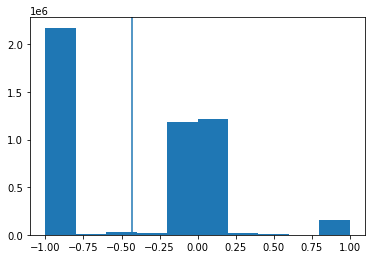

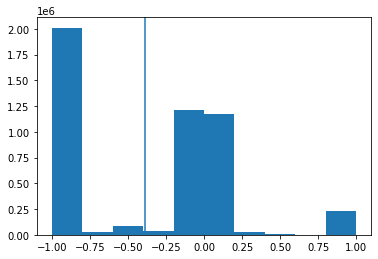

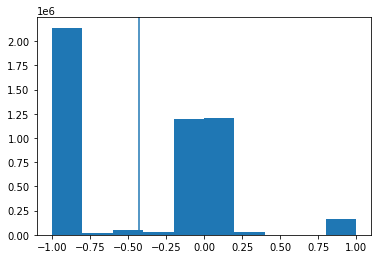

In [5]:
# Visualize the data distribution for 10 random batches (the data should in between -1 and 1)
for i in range(3):
    data = next(iter(train_loader))
    plt.hist(data[0].flatten())
    plt.axvline(data[0].mean())
    plt.show()

## Create a CNN for the diameter regression on the 4-channel XYZA images

In [6]:
# load an existing model from torchvision, including the pretrained weights:
model = models.resnext101_32x8d(pretrained=True)

# change the fully connected layer so that we can do regression (last layer: linear wit one output to estimate the diameter)
model.fc = nn.Sequential(nn.Linear(2048, 512), nn.ReLU(), nn.Dropout(0.2), nn.Linear(512, 1))

# thanks to: https://stackoverflow.com/questions/62629114/how-to-modify-resnet-50-with-4-channels-as-input-using-pre-trained-weights-in-py
pretrained_weights = model.conv1.weight.clone()

# change the resnet input architecture so that we can train on 4-channel images 
model.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)

# duplicate the pretrained weights over all channels (4)
weights = torch.zeros([64, 4, 7, 7], dtype=torch.float32)
weights[:,:3,:,:] = pretrained_weights
weights[:,3,:,:] = pretrained_weights[:,1,:,:]
model.conv1.weight = torch.nn.Parameter(weights)

## Specify the optimizer and the loss function

In [7]:
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=4e-3, amsgrad=True)
criterion = nn.SmoothL1Loss()

model.to(device)

ResNet(
  (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

## Initialize the training procedure

In [8]:
weights_dir = "./weights"
analysis_name = "diameter_regression"

writedir = os.path.join(weights_dir, analysis_name)
if not os.path.exists(writedir):
    os.makedirs(writedir)

epochs = 100
start = time.time()
history = []

lossfile = os.path.join(writedir, 'loss_log.txt')

if os.path.exists(lossfile):
    os.remove(lossfile)

with open(lossfile, 'w') as txtfile:
    txtfile.write("epoch,train_loss,val_loss")
    txtfile.write("\r\n")

## Train the CNN regression network

Epoch: 1/100
Training loss: 38.0665, Validation loss : 25.4456, Time: 47.4019 s
Epoch: 2/100
Training loss: 9.4411, Validation loss : 19.8162, Time: 46.7115 s
Epoch: 3/100
Training loss: 8.9027, Validation loss : 9.0056, Time: 46.4153 s
Epoch: 4/100
Training loss: 9.5007, Validation loss : 11.7705, Time: 46.7900 s
Epoch: 5/100
Training loss: 8.5832, Validation loss : 10.0668, Time: 46.7243 s
Epoch: 6/100
Training loss: 7.5207, Validation loss : 10.2812, Time: 46.9960 s
Epoch: 7/100
Training loss: 7.4629, Validation loss : 8.9575, Time: 47.0250 s
Epoch: 8/100
Training loss: 7.3503, Validation loss : 16.7093, Time: 48.0771 s
Epoch: 9/100
Training loss: 7.1528, Validation loss : 9.5851, Time: 45.7998 s
Epoch: 10/100
Training loss: 7.5585, Validation loss : 10.9570, Time: 46.1228 s
Epoch: 11/100
Training loss: 7.0557, Validation loss : 8.6286, Time: 45.6886 s
Epoch: 12/100
Training loss: 7.3910, Validation loss : 17.4243, Time: 45.5955 s
Epoch: 13/100
Training loss: 6.9195, Validation loss

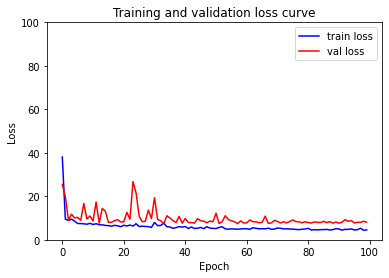

In [9]:
# training loop extracted from: https://github.com/spmallick/learnopencv/blob/master/Image-Classification-in-PyTorch/image_classification_using_transfer_learning_in_pytorch.ipynb

for epoch in range(epochs):
    epoch_start = time.time()
    print("Epoch: {}/{}".format(epoch+1, epochs))
    
    # Set to training mode
    model.train()
    
    # Loss within the epoch
    train_loss = 0.0
    valid_loss = 0.0
    
    for i, (inputs, labels) in enumerate(train_loader):

        inputs = inputs.to(device)
        labels = labels.to(device)

        if labels.ndim == 1:
            labels = labels.view(labels.shape[0], 1)
        
        # Clean existing gradients
        optimizer.zero_grad()
        
        # Forward pass - compute outputs on input data using the model
        outputs = model(inputs)
        
        # Compute loss
        loss = criterion(outputs, labels)
        
        # Backpropagate the gradients
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
        # Compute the total loss for the batch and add it to train_loss
        train_loss += loss.item() * inputs.size(0)

        
    # Validation - No gradient tracking needed
    with torch.no_grad():

        # Set to evaluation mode
        model.eval()

        # Validation loop
        for j, (inputs, labels) in enumerate(val_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            if labels.ndim == 1:
                labels = labels.view(labels.shape[0], 1)

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Compute the total loss for the batch and add it to valid_loss
            valid_loss += loss.item() * inputs.size(0)

            
    # Find average training loss
    avg_train_loss = train_loss/len(train_dataset) 

    # Find average training loss 
    avg_valid_loss = valid_loss/len(val_dataset)

    history.append([avg_train_loss, avg_valid_loss])
            
    epoch_end = time.time()

    print("Training loss: {:.4f}, Validation loss : {:.4f}, Time: {:.4f} s".format(avg_train_loss, avg_valid_loss, epoch_end-epoch_start))
    
    # Save the model for every epoch:
    torch.save(model, writedir + '/epoch_' + str(epoch+1).zfill(3) + '.pt')

    with open(lossfile, 'a') as txtfile:
        txtfile.write(str(epoch+1))
        txtfile.write(',')
        txtfile.write('%.4f' % avg_train_loss)
        txtfile.write(',')
        txtfile.write('%.4f' % avg_valid_loss)
        txtfile.write("\r\n")

epoch = np.arange(epochs)
train_loss_history = [loss[0] for loss in history]
val_loss_history = [loss[1] for loss in history]

plt.plot(epoch, train_loss_history, "-b", label="train loss")
plt.plot(epoch, val_loss_history, "-r", label="val loss")
plt.legend(loc="upper right")
plt.title("Training and validation loss curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(0, epochs)
plt.show()

txtfile.close()